# XGBoost Anomaly Detection for CMS Open Payments

**Project:** AAI-540 Machine Learning Operations - Final Team Project  
**Context:** Continuation of notebook 02 - Data Exploration & Analysis  
**Objective:** Train an XGBoost model to detect anomalous payment patterns using gradient boosted decision trees

---

## Table of Contents
1. [Setup & Data Loading](#setup)
2. [Load Data from Stored Variables](#loading)
3. [Data Preparation & Feature Engineering](#preparation)
4. [XGBoost Configuration](#configuration)
5. [Model Training](#training)
6. [Performance Evaluation](#evaluation)
7. [Anomaly Score Calculation & Validation](#scoring)
8. [Visualizations & Metrics](#visualizations)
9. [Summary & Outputs](#summary)

---

## 1. Setup & Data Loading

Load dependencies and restore configuration from notebook 02 (EDA).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import sys
sys.path.append('..')

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb
from utils.visualizations import ModelVisualizer

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

model_viz = ModelVisualizer()

In [2]:
%store -r bucket
%store -r region
%store -r database_name
%store -r table_name_parquet
%store -r s3_parquet_path
%store -r s3_athena_staging
%store -r df

if 'df' not in dir() or df is None:
    raise NameError("Missing required variable 'df'. Run notebook 02 first.")
    
print(f"Region: {region} | Bucket: {bucket} | Database: {database_name}")
print(f"Dataset shape: {df.shape}")

no stored variable or alias s3_parquet_path
Region: us-east-1 | Bucket: cmsopenpaymentsystemslight | Database: cms_open_payments_light
Dataset shape: (997362, 31)


## 2. Load Data from Stored Variables

Use the cleaned and processed dataset from notebook 02.

In [3]:
df_payments = df.copy()
display(df_payments.head(3))
print(f"Dataset loaded: {df_payments.shape}")

,total_amount_of_payment_usdollars,number_of_payments_included_in_total_amount,date_of_payment,covered_recipient_type,nature_of_payment_or_transfer_of_value,form_of_payment_or_transfer_of_value,recipient_state,covered_recipient_profile_id,covered_recipient_npi,applicable_manufacturer_or_applicable_gpo_making_payment_name,...,hist_pay_std,hist_pay_max,amt_to_avg_ratio,amt_to_max_ratio,is_new_recipient,is_high_risk_nature,total_amount_of_payment_usdollars_scaled,hist_pay_avg_scaled,hist_pay_std_scaled,amt_to_avg_ratio_scaled
0,21.68,1.0,2024-05-01,Covered Recipient Physician,Food and Beverage,In-kind items and services,NJ,189597.0,1.174589493E9,Bayer Healthcare Pharmaceuticals Inc.,...,0.000000,21.68,1.00000,1.000000,0,0,-0.006531,-0.007226,-0.006588,2.258894e-16
1,20.02,19.0,2024-05-01,Covered Recipient Non-Physician Practitioner,1,07/09/2024,MO,1.1436307E7,1.598470684E9,100000000226,...,2.588011,18.11,1.22973,1.105467,0,0,-0.006531,-0.007226,-0.006588,4.674152e-01
2,20.02,64.0,2024-05-01,Covered Recipient Physician,1,02/28/2024,OH,268013.0,1.912181389E9,100000186746,...,0.000000,20.02,1.00000,1.000000,0,0,-0.006531,-0.007226,-0.006588,2.258894e-16


Dataset loaded: (997362, 31)


## 3. Data Preparation & Feature Engineering

Prepare features for XGBoost training with appropriate preprocessing.

In [4]:
# Select numeric features for anomaly detection
numeric_cols = df_payments.select_dtypes(include=[np.number]).columns.tolist()

# Exclude identifier and non-relevant columns
cols_to_exclude = [
    'EventTime', 'covered_recipient_profile_id', 'index',
    'teaching_hospital_id', 'covered_recipient_npi',
    'recipient_zip_code', 'recipient_province', 'recipient_postal_code'
]

numeric_features = [col for col in numeric_cols 
                   if col not in cols_to_exclude 
                   and not any(x in col.lower() for x in ['_id', '_code', '_province', '_postal'])]

# Create feature matrix
X = df_payments[numeric_features].copy().astype(float)
X = X.replace([np.inf, -np.inf], np.nan)

# Remove columns with excessive missing values (>50%)
missing_pct = (X.isnull().sum() / len(X)) * 100
cols_to_keep = missing_pct[missing_pct <= 50].index.tolist()
X = X[cols_to_keep]

# Handle outliers using IQR method
for col in X.columns:
    q1, q3 = X[col].quantile(0.25), X[col].quantile(0.75)
    iqr = q3 - q1
    X[col] = X[col].clip(lower=q1 - 3*iqr, upper=q3 + 3*iqr)

# Fill remaining missing values with median
X = X.fillna(X.median())

print(f"Features prepared: {X.shape}")

Features prepared: (997362, 20)


In [5]:
# For XGBoost anomaly detection, we use a semi-supervised approach:
# 1. Create pseudo-labels using Isolation Forest from previous notebook
# 2. Or use statistical thresholds to create initial labels

# Create synthetic labels based on statistical outliers
# We'll use multiple indicators to create initial labels
outlier_indicators = []

for col in X.columns:
    # Use Z-score method
    z_scores = np.abs((X[col] - X[col].mean()) / X[col].std())
    outlier_indicators.append((z_scores > 3).astype(int))

# Combine outlier indicators (if any feature is outlier, mark as potential anomaly)
outlier_score = pd.DataFrame(outlier_indicators).T.sum(axis=1)

# Create labels: top 5% of outlier scores are labeled as anomalies
threshold_percentile = 95
threshold_value = np.percentile(outlier_score, threshold_percentile)
y_pseudo = (outlier_score >= threshold_value).astype(int)

anomaly_ratio = y_pseudo.sum() / len(y_pseudo)
print(f"Pseudo-labels created: {y_pseudo.sum():,} anomalies ({anomaly_ratio*100:.2f}%)")
print(f"Normal samples: {(y_pseudo==0).sum():,} ({(1-anomaly_ratio)*100:.2f}%)")

Pseudo-labels created: 84,747 anomalies (8.50%)
Normal samples: 912,615 (91.50%)


In [6]:
# Scale features using RobustScaler (better for outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_pseudo, 
    test_size=0.2, 
    random_state=42,
    stratify=y_pseudo
)

print(f"Train: {len(X_train):,} ({y_train.sum()} anomalies) | Test: {len(X_test):,} ({y_test.sum()} anomalies)")

Train: 797,889 (67798 anomalies) | Test: 199,473 (16949 anomalies)


## 4. XGBoost Configuration

Configure the XGBoost model with optimal hyperparameters for anomaly detection.

In [7]:
# Calculate scale_pos_weight for imbalanced dataset
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# XGBoost hyperparameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': scale_pos_weight,
    'early_stopping_rounds': 20,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}

print(f"XGBoost configured: depth={xgb_params['max_depth']}, lr={xgb_params['learning_rate']}, n_est={xgb_params['n_estimators']}")

XGBoost configured: depth=6, lr=0.1, n_est=200


## 5. Model Training

Train the XGBoost model on the prepared dataset with early stopping.

In [8]:
# Initialize and train XGBoost Classifier
xgb_model = xgb.XGBClassifier(**xgb_params)

start_time = time.time()

# Fit the model with evaluation set
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

training_time = time.time() - start_time

# Check if early stopping was used (safely)
try:
    best_iter = xgb_model.best_iteration
    print(f"Training completed: {training_time:.2f}s | Best iteration: {best_iter} | Best score: {xgb_model.best_score:.6f}")
except AttributeError:
    print(f"Training completed: {training_time:.2f}s | Iterations: {xgb_params['n_estimators']}")

Training completed: 10.21s | Best iteration: 71 | Best score: 0.999992


### Training Curve Analysis

Visualize the learning curves from the training process.

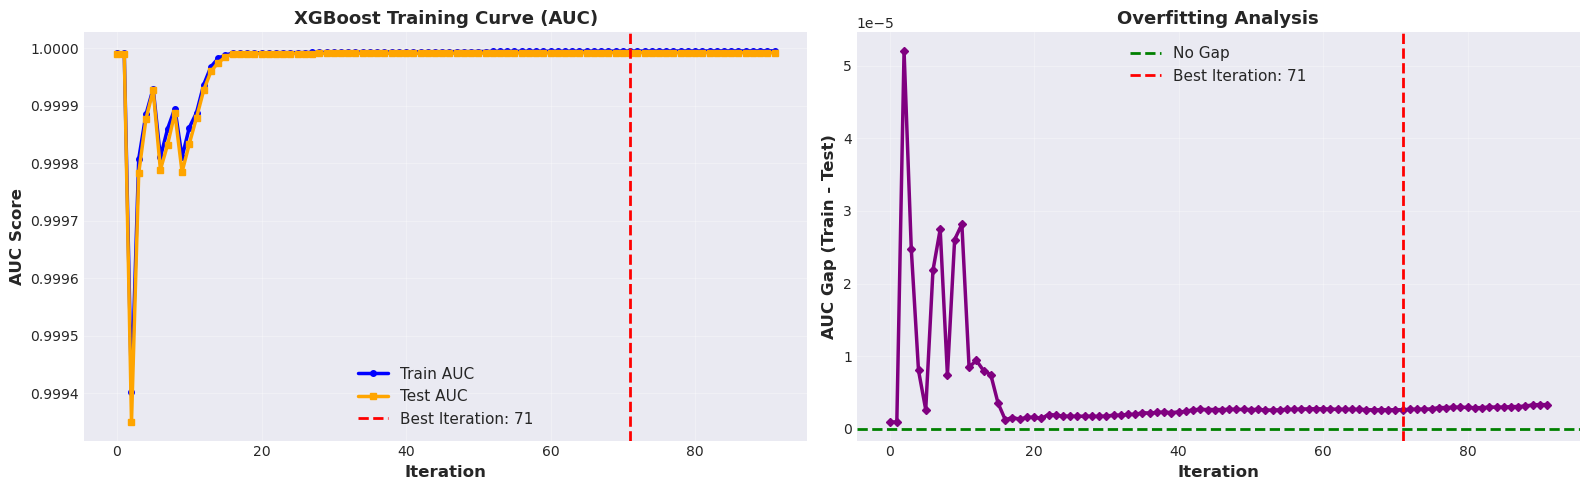

Train AUC: 1.0000 → 1.0000 | Test AUC: 1.0000 → 1.0000 (best: 1.0000)


In [9]:
# Extract evaluation results
results = xgb_model.evals_result()

# Get best iteration if available (safely)
try:
    best_iter = xgb_model.best_iteration
except AttributeError:
    best_iter = None

# Plot training curves using ModelVisualizer
fig = model_viz.plot_xgboost_training_curves(
    results=results,
    best_iteration=best_iter
)
plt.show()

# Print summary
train_auc = results['validation_0']['auc']
test_auc = results['validation_1']['auc']

print(f"Train AUC: {train_auc[0]:.4f} → {train_auc[-1]:.4f} | Test AUC: {test_auc[0]:.4f} → {test_auc[-1]:.4f} (best: {max(test_auc):.4f})")

## 6. Performance Evaluation

Evaluate model performance and generate predictions on train and test sets.

In [10]:
# Generate predictions and probabilities
train_pred = xgb_model.predict(X_train)
train_proba = xgb_model.predict_proba(X_train)[:, 1]  # Probability of anomaly

test_pred = xgb_model.predict(X_test)
test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate AUC scores
train_auc_score = roc_auc_score(y_train, train_proba)
test_auc_score = roc_auc_score(y_test, test_proba)

print(f"Performance: Train AUC={train_auc_score:.6f} | Test AUC={test_auc_score:.6f}")
print(f"\nTest Classification Report:")
print(classification_report(y_test, test_pred, target_names=['Normal', 'Anomaly']))

Performance: Train AUC=0.999995 | Test AUC=0.999992

Test Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    182524
     Anomaly       0.98      1.00      0.99     16949

    accuracy                           1.00    199473
   macro avg       0.99      1.00      1.00    199473
weighted avg       1.00      1.00      1.00    199473



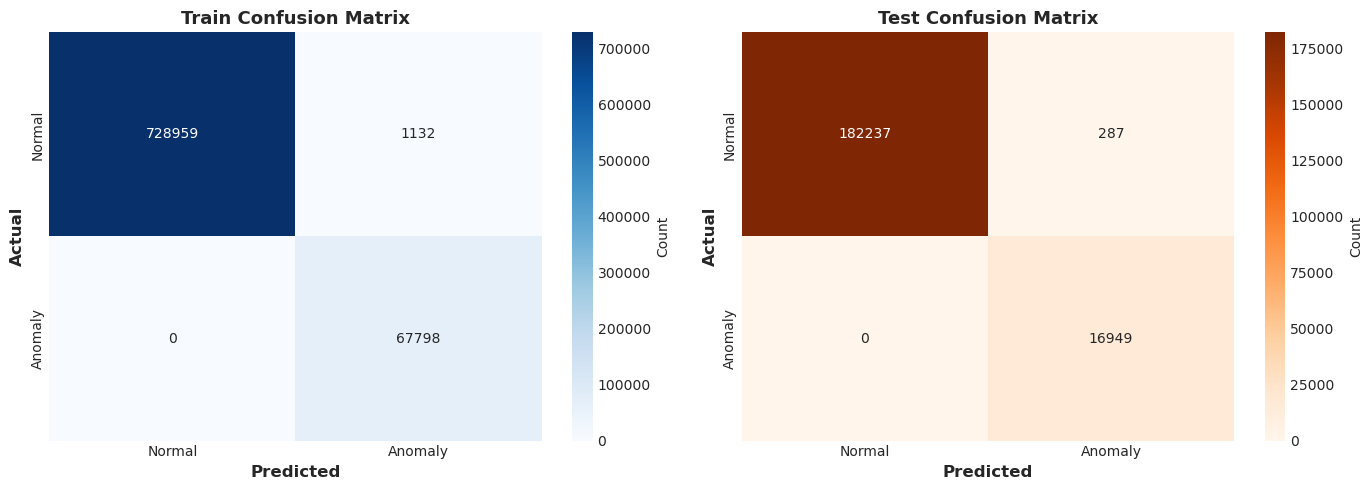

In [11]:
# Plot confusion matrices using ModelVisualizer
fig = model_viz.plot_confusion_matrices(
    y_train=y_train,
    train_pred=train_pred,
    y_test=y_test,
    test_pred=test_pred
)
plt.show()

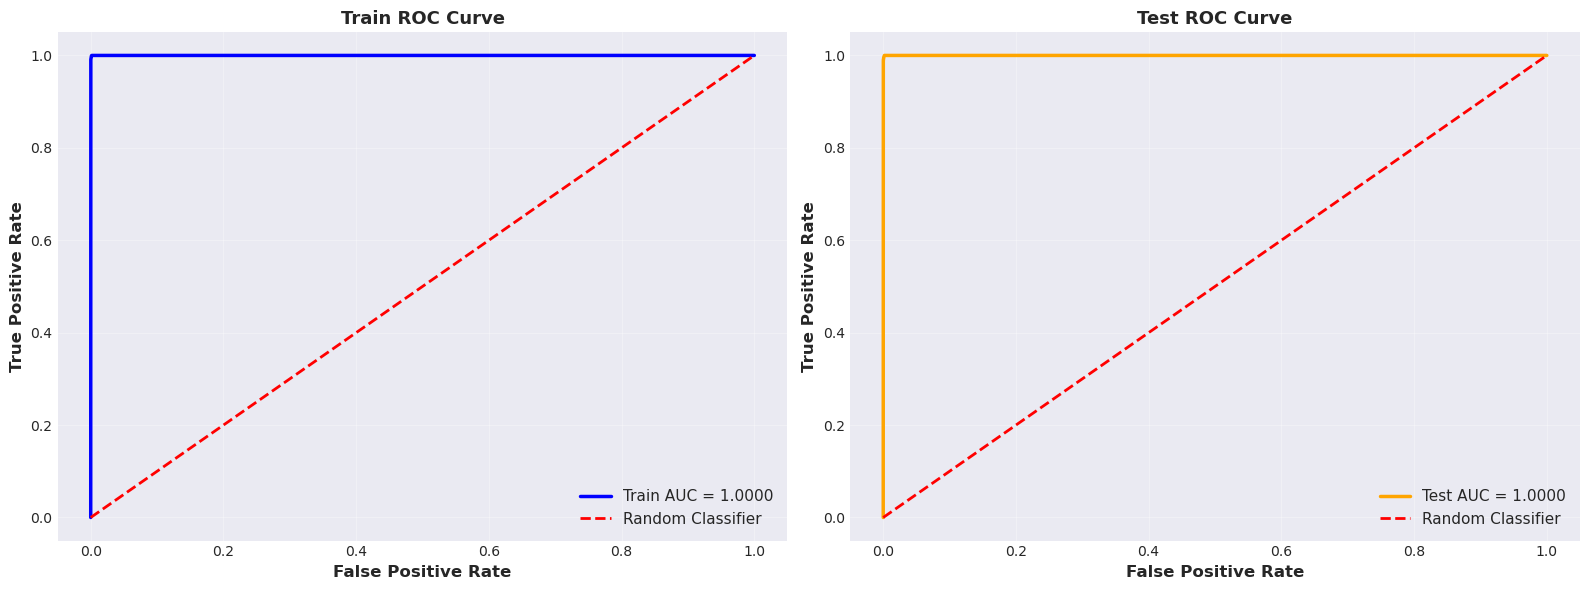

In [12]:
# Plot ROC curves using ModelVisualizer
fig = model_viz.plot_roc_curves(
    y_train=y_train,
    train_proba=train_proba,
    y_test=y_test,
    test_proba=test_proba,
    train_auc=train_auc_score,
    test_auc=test_auc_score
)
plt.show()

## 7. Anomaly Score Calculation & Validation

Calculate anomaly scores and validate detected anomalies with payment details.

In [13]:
# Combine all data for comprehensive analysis
all_data = pd.concat([X_train, X_test], axis=0)
all_labels = pd.concat([pd.Series(y_train.values, index=X_train.index), 
                        pd.Series(y_test.values, index=X_test.index)])

# Get predictions and probabilities for all data
all_pred = xgb_model.predict(all_data)
all_proba = xgb_model.predict_proba(all_data)[:, 1]

# Use probability as anomaly score (higher = more likely anomaly)
anomaly_scores = all_proba

# Set threshold at 0.5 (default) or optimize based on requirements
threshold = 0.5
anomaly_labels = (all_proba >= threshold).astype(int)

anomaly_count = anomaly_labels.sum()
anomaly_percentage = (anomaly_count / len(anomaly_labels)) * 100

print(f"Threshold: {threshold:.4f} | Anomalies: {anomaly_count:,}/{len(anomaly_labels):,} ({anomaly_percentage:.2f}%)")
print(f"Score range: [{anomaly_scores.min():.4f}, {anomaly_scores.max():.4f}] | Mean: {anomaly_scores.mean():.4f}")

Threshold: 0.5000 | Anomalies: 86,166/997,362 (8.64%)
Score range: [0.0003, 0.9997] | Mean: 0.0867


### Validation: Inspect Detected Anomalies

Examine the payment details of detected anomalies to validate model performance.

In [14]:
# Create results dataframe with anomaly scores
anomaly_results = df_payments.copy()
anomaly_results['anomaly_score'] = anomaly_scores
anomaly_results['is_anomaly'] = anomaly_labels
anomaly_results['anomaly_score_percentile'] = pd.Series(anomaly_scores).rank(pct=True) * 100

# Filter anomalies and normal payments
anomalies_df = anomaly_results[anomaly_results['is_anomaly'] == 1].copy()
anomalies_df = anomalies_df.sort_values('anomaly_score', ascending=False)  # Higher scores = more anomalous
normal_df = anomaly_results[anomaly_results['is_anomaly'] == 0]

# Display top anomalies using ModelVisualizer
top_anomalies = model_viz.display_top_anomalies(
    anomalies_df=anomalies_df,
    score_col='anomaly_score',
    top_n=10
)
display(top_anomalies)

# Statistical comparison using ModelVisualizer
comparison_features = ['total_amount_of_payment_usdollars']
optional_comparison = ['amt_to_avg_ratio', 'hist_pay_avg']
for col in optional_comparison:
    if col in anomaly_results.columns:
        comparison_features.append(col)

comparison_stats = model_viz.print_anomaly_stats(
    normal_df=normal_df,
    anomaly_df=anomalies_df,
    score_col='anomaly_score',
    comparison_features=comparison_features
)


=== Top 10 Anomalous Payments (n=86,166) ===


,anomaly_score,anomaly_score_percentile,total_amount_of_payment_usdollars,covered_recipient_type,nature_of_payment_or_transfer_of_value,amt_to_avg_ratio,hist_pay_avg,is_new_recipient,is_weekend,is_high_risk_nature
715705,0.999671,99.993332,9.72,Covered Recipient Non-Physician Practitioner,Food and Beverage,0.910539,10.675000,0,0,0
604524,0.999671,99.993332,18.81,Covered Recipient Physician,Food and Beverage,0.281376,66.850000,0,0,0
936290,0.999671,99.993332,20.02,Covered Recipient Non-Physician Practitioner,In-kind items and services,1.000000,20.020000,0,0,0
884764,0.999671,99.993332,158.31,Covered Recipient Physician,Food and Beverage,1.000000,158.310000,0,1,0
540623,0.999671,99.993332,17.22,Covered Recipient Physician,Food and Beverage,0.984000,17.500000,0,0,0
667699,0.999671,99.993332,20.02,Covered Recipient Non-Physician Practitioner,10/23/2024,1.000000,20.020000,0,1,0
171579,0.999671,99.993332,20.84,Covered Recipient Non-Physician Practitioner,Food and Beverage,1.040959,20.020000,0,0,0
229575,0.999671,99.993332,21.64,Covered Recipient Non-Physician Practitioner,Food and Beverage,0.827059,26.165000,0,0,0
982864,0.999671,99.993332,18.50,Covered Recipient Non-Physician Practitioner,Food and Beverage,1.134969,16.300000,0,0,0
761932,0.999671,99.993332,7.41,Covered Recipient Non-Physician Practitioner,Food and Beverage,0.163914,45.206667,0,0,0



=== Statistical Comparison ===
                                   Normal_Mean  Normal_Median  Anomaly_Mean  \
total_amount_of_payment_usdollars    64.776156          20.02     63.312720   
amt_to_avg_ratio                      1.656102           1.00      1.668886   
hist_pay_avg                         58.892288          20.02     56.687075   

                                   Anomaly_Median  Difference_%  
total_amount_of_payment_usdollars           20.02     -2.259219  
amt_to_avg_ratio                             1.00      0.771973  
hist_pay_avg                                20.02     -3.744484  

=== Anomaly Score Statistics ===
   Metric    Normal   Anomaly
0    Mean  0.000752  0.995451
1  Median  0.000357  0.999244
2     Min  0.000287  0.504114
3     Max  0.498969  0.999671


In [15]:
# Anomaly distribution by key categories
categorical_cols = ['covered_recipient_type', 'nature_of_payment_or_transfer_of_value']
optional_categorical = ['is_high_risk_nature', 'is_weekend', 'is_new_recipient']

for col in optional_categorical:
    if col in anomalies_df.columns:
        categorical_cols.append(col)

categorical_cols = [col for col in categorical_cols if col in anomalies_df.columns]

if categorical_cols:
    print("Top Anomaly Categories:")
    for col in categorical_cols[:2]:  # Show only first 2
        print(f"\n{col}:")
        print(anomalies_df[col].value_counts().head(3))

Top Anomaly Categories:

covered_recipient_type:
covered_recipient_type
Covered Recipient Physician                     55330
Covered Recipient Non-Physician Practitioner    30836
Name: count, dtype: Int64

nature_of_payment_or_transfer_of_value:
nature_of_payment_or_transfer_of_value
Food and Beverage             43933
1                             30629
In-kind items and services     4115
Name: count, dtype: Int64


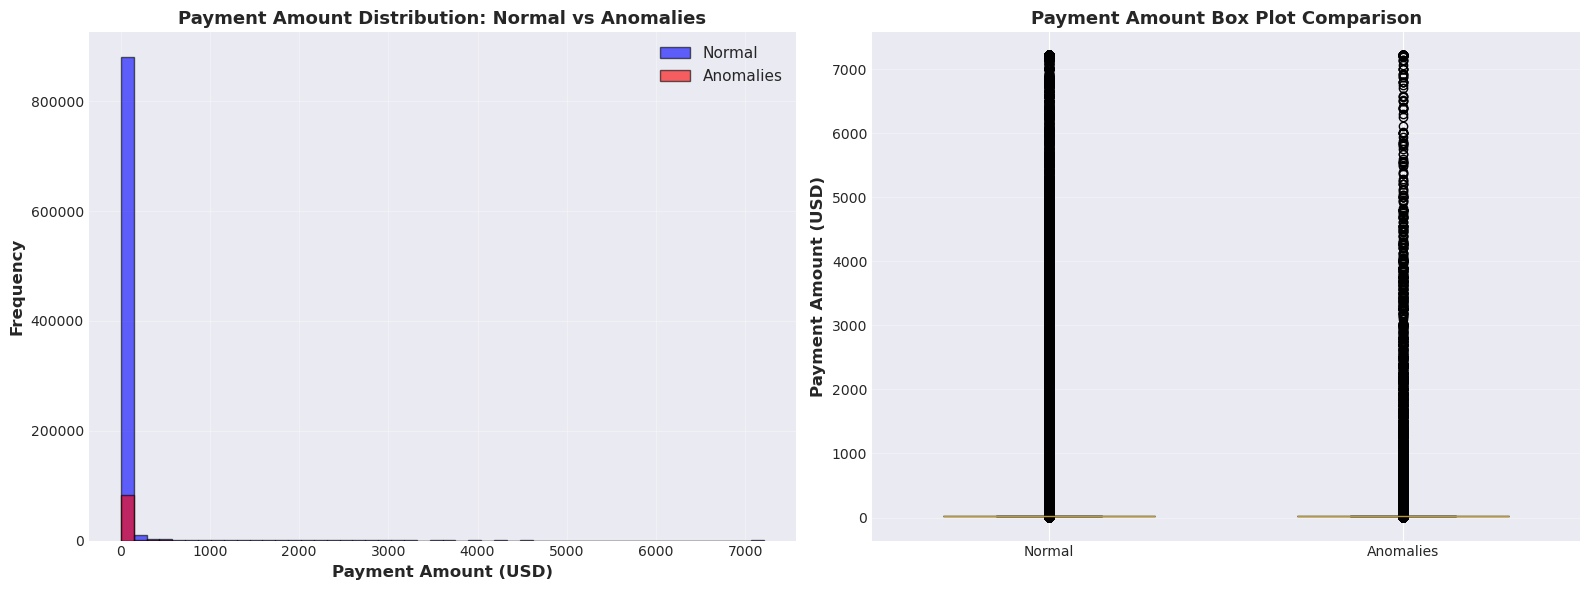

In [16]:
# Visualize payment amount distribution: Normal vs Anomalies using ModelVisualizer
if 'total_amount_of_payment_usdollars' in anomaly_results.columns:
    fig = model_viz.plot_anomaly_comparison(
        normal_df=normal_df,
        anomaly_df=anomalies_df,
        amount_col='total_amount_of_payment_usdollars',
        score_col='anomaly_score'
    )
    plt.show()

## 8. Visualizations & Metrics

Visualize anomaly scores, feature importance, and model performance metrics.

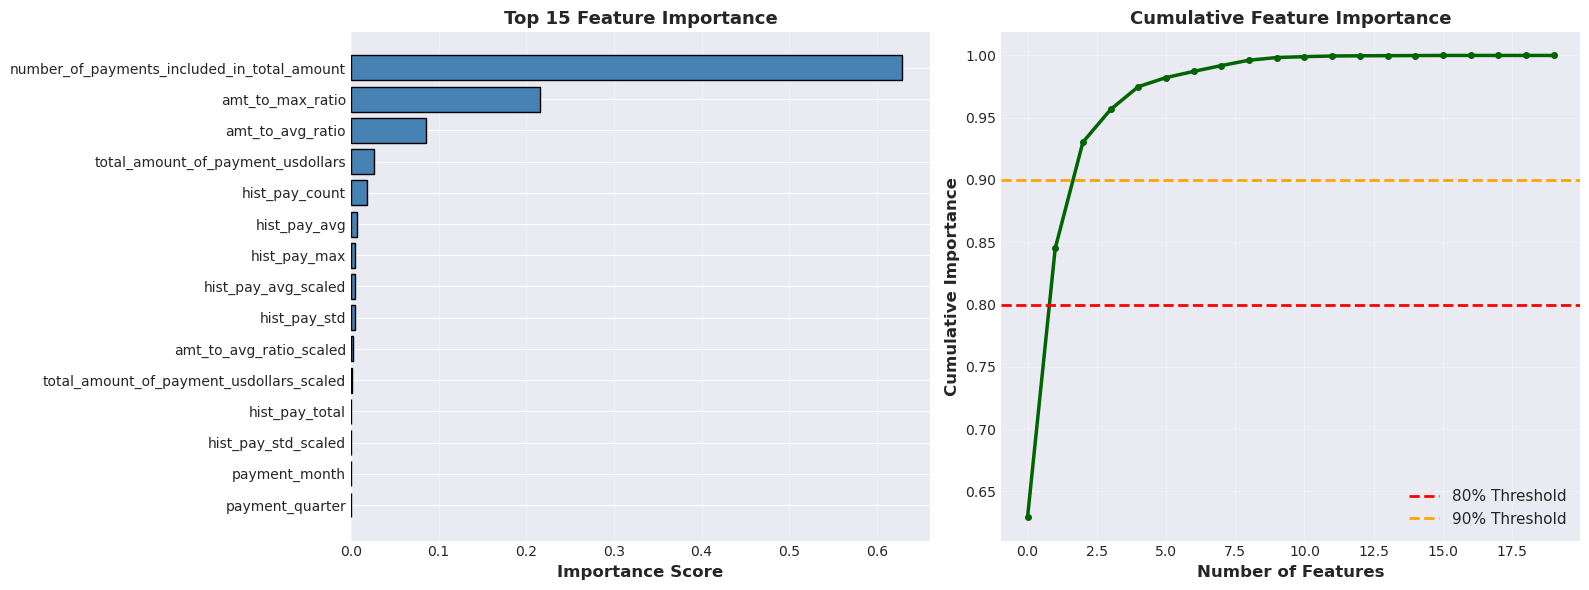


Top 10 Most Important Features:


,feature,importance
1,number_of_payments_included_in_total_amount,0.629028
13,amt_to_max_ratio,0.216052
12,amt_to_avg_ratio,0.085252
0,total_amount_of_payment_usdollars,0.026274
7,hist_pay_count,0.018301
9,hist_pay_avg,0.007296
11,hist_pay_max,0.004987
17,hist_pay_avg_scaled,0.004659
10,hist_pay_std,0.004322
19,amt_to_avg_ratio_scaled,0.002150


In [17]:
# Plot feature importance using ModelVisualizer
fig, feature_importance = model_viz.plot_feature_importance(
    feature_names=X.columns,
    feature_importances=xgb_model.feature_importances_,
    top_n=15
)
plt.show()

print("\nTop 10 Most Important Features:")
display(feature_importance.head(10))

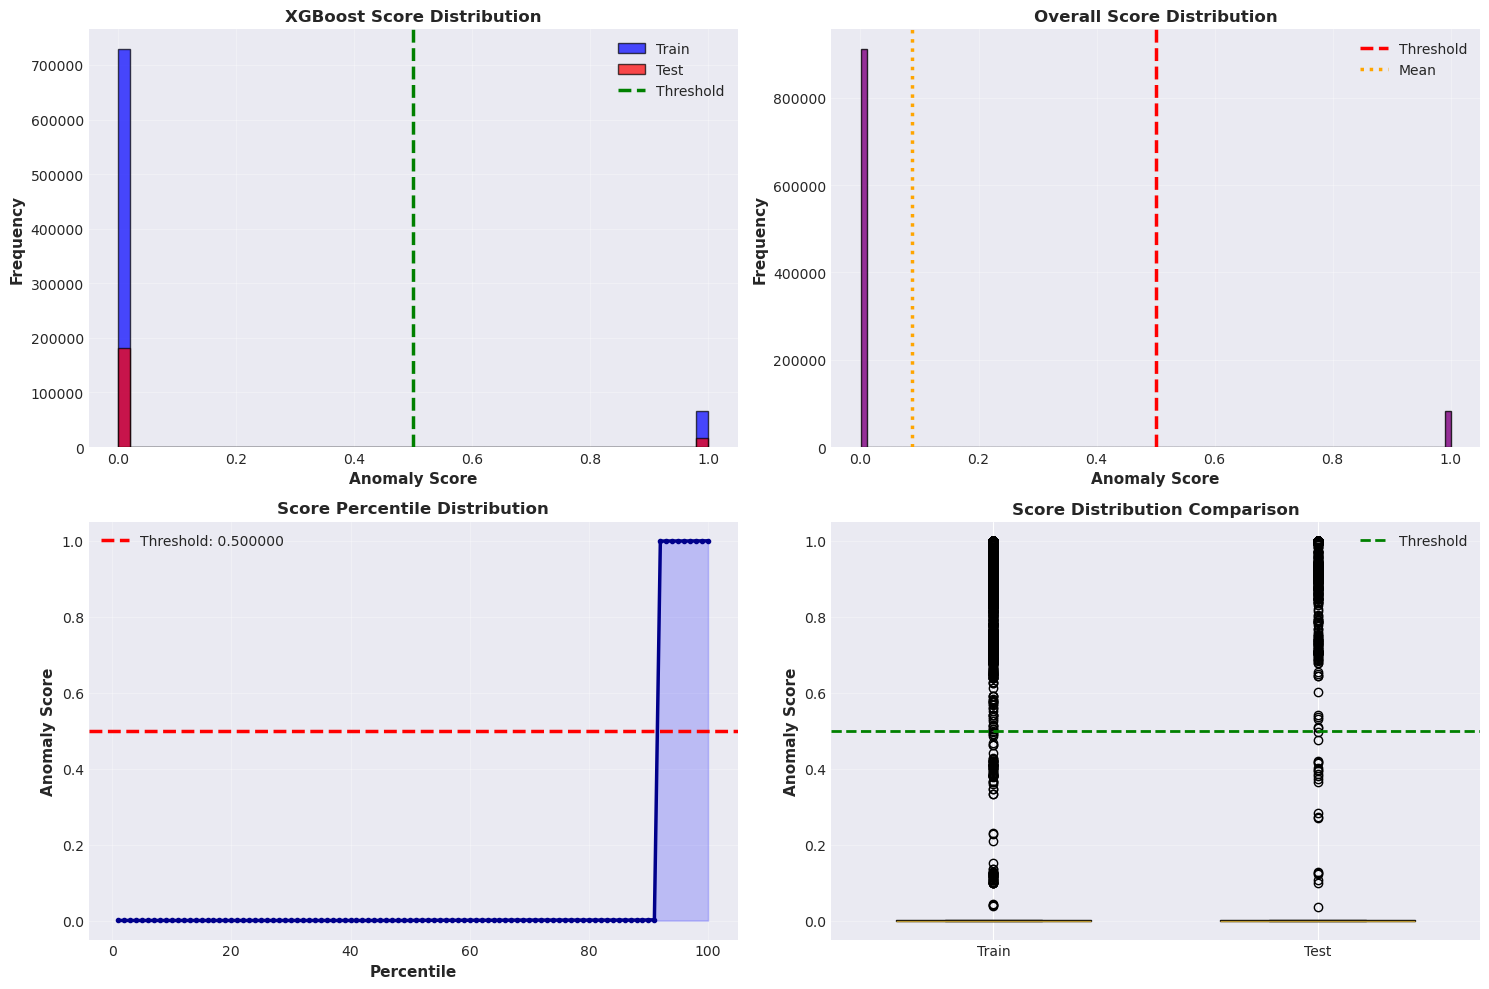

In [18]:
# Plot comprehensive anomaly score analysis using ModelVisualizer
fig = model_viz.plot_anomaly_scores(
    train_scores=train_proba,
    test_scores=test_proba,
    threshold=threshold,
    model_name='XGBoost'
)
plt.show()

## 9. Summary & Outputs

Save model and anomaly detection results for downstream analysis.

In [19]:
# Save model artifacts
with open('cms_xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

with open('xgboost_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

anomaly_results.to_csv('anomaly_results_xgboost.csv', index=False)
feature_importance.to_csv('xgboost_feature_importance.csv', index=False)

print("Saved: model, scaler, results, feature importance")

Saved: model, scaler, results, feature importance


In [20]:
# Execution summary
results_summary = pd.DataFrame({
    'Metric': ['Total Records', 'Train/Test Split', 'Anomalies Detected', 
               'Train AUC', 'Test AUC', 'Training Time (s)', 'Top Feature'],
    'Value': [
        len(anomaly_labels), 
        f"{len(X_train):,}/{len(X_test):,}",
        f"{anomaly_count:,} ({anomaly_percentage:.2f}%)",
        f"{train_auc_score:.4f}",
        f"{test_auc_score:.4f}",
        f"{training_time:.2f}",
        f"{feature_importance.iloc[0]['feature']} ({feature_importance.iloc[0]['importance']:.4f})"
    ]
})

display(results_summary)

print(f"\nScore Separation: Normal={normal_df['anomaly_score'].mean():.4f} | Anomaly={anomalies_df['anomaly_score'].mean():.4f} | Gap={anomalies_df['anomaly_score'].mean() - normal_df['anomaly_score'].mean():.4f}")

,Metric,Value
0,Total Records,997362
1,Train/Test Split,"797,889/199,473"
2,Anomalies Detected,"86,166 (8.64%)"
3,Train AUC,1.0000
4,Test AUC,1.0000
5,Training Time (s),10.21
6,Top Feature,number_of_payments_included_in_total_amount (0...



Score Separation: Normal=0.0008 | Anomaly=0.9955 | Gap=0.9947
